# Integrate scRNA-seq and CODEX datasets from HPAP023 donor 

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

import anndata as ad
import scanpy as sc
import cellink
from cellink import Cellink


## Read scRNA-seq and CODEX datasets

In [5]:
# read in rna data
rna = pd.read_csv('/Users/luosanj/Desktop/project2/data/HPAP023/HPAP-023_exp_mat.csv')

In [6]:
rna_feature = rna.iloc[:,0]
rna_obs = rna.columns[1:]
rna_mat = rna.iloc[:, 1:].to_numpy().T
# convert to anndata
rna_adata = ad.AnnData(rna_mat, dtype = np.float32)
rna_adata.var_names = rna_feature
rna_adata.obs_names = rna_obs
# read in cell type labels of scRNA
rna_ct = pd.read_csv('/Users/luosanj/Desktop/project2/data/HPAP_cell_annotations/HPAP-023_cell_annotations.csv')
label_rna = rna_ct['Celltype'].to_numpy()
rna_adata.obs['cell_type'] = label_rna

/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [7]:
protein_adata = sc.read_h5ad('/Users/luosanj/Desktop/project2/data/HPAP023/HPAP023-T1D-17y-7y-F-T_3_2_2-OCT.h5ad')

In [8]:
protein_adata = protein_adata[protein_adata.obs['cell_type'] != 'Unidentified'].copy()

In [9]:
# select a sub-region 
protein_adata_filter = protein_adata[(protein_adata.obsm['spatial'][:,0] > 5000) & 
                                     (protein_adata.obsm['spatial'][:,1] < 5000)]

## Align cell-type label between two datasets

In [10]:
def map_cell_types(cell_type):
    if cell_type in ['Lymphatic Endothelial Cell', 'Vascular Endothelial Cell']:
        return 'Endothelial'
    elif cell_type in ['T Cell', 'Macrophage Cell', 'Monocyte or Dendritic Cell']:
        return 'Immune'
    elif cell_type in ['Gamma Cell', 'Delta Cell']:
        return 'Delta-PP'
    elif cell_type == 'Exxocrine Cell':
        return 'Exocrine'
    elif cell_type == 'Exocrine Cell':
        return 'Exocrine'
    elif cell_type == 'Duct Cell':
        return 'Ductal'
    elif cell_type == 'Alpha Cell':
        return 'Alpha'
    elif cell_type == 'Acinar':
        return 'Exocrine'
    elif cell_type == 'Beta Cell':
        return 'Beta'
    else:
        return cell_type  # Return the original name if it doesn't match the above

# Apply the mapping function to each cell type in the 'cell_type' column
rna_adata.obs['cell_type'] = rna_adata.obs['cell_type'].apply(map_cell_types)
protein_adata_filter.obs['cell_type'] = protein_adata_filter.obs['cell_type'].apply(map_cell_types)

/var/folders/zz/067t14gd4nj4836tcg_c5prw0000gt/T/ipykernel_63606/1918363788.py:25: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  protein_adata_filter.obs['cell_type'] = protein_adata_filter.obs['cell_type'].apply(map_cell_types)


## Data normalization

/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


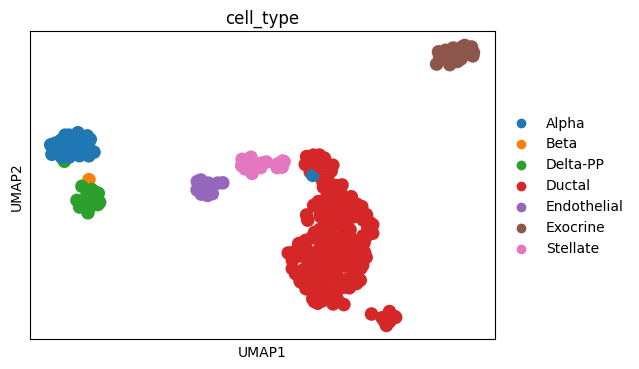

In [11]:
# # process all RNA features
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
#sc.pp.scale(rna_adata)
sc.pp.highly_variable_genes(rna_adata, n_top_genes=5000)
# # only retain highly variable genes
rna_adata1 = rna_adata[:, rna_adata.var.highly_variable].copy()
# # plot UMAPs of rna cells based on all active rna markers

sc.pp.neighbors(rna_adata1, n_neighbors=15)
sc.tl.umap(rna_adata1)
sc.pl.umap(rna_adata1, color='cell_type')

## Extract linked features between two datasets

In [12]:
correspondence = pd.read_csv('/Users/luosanj/Desktop/project2/data/protein_gene_relationship.csv')
rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata1.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
            
rna_protein_correspondence = np.array(rna_protein_correspondence)

In [13]:
# correspondence information
rna_shared = rna_adata1[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata_filter[:, rna_protein_correspondence[:, 1]].copy()

/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Generate the all-feature and linked-feature profiles of two datasets

In [14]:
extract_ct = ['Alpha', 'Exocrine', 'Delta-PP', 'Ductal']
rna_shared = rna_shared[rna_shared.obs['cell_type'].isin(extract_ct)]
protein_shared = protein_shared[protein_shared.obs['cell_type'].isin(extract_ct)]
combined_adata = rna_adata1[rna_adata1.obs['cell_type'].isin(extract_ct)]
protein_adata_filter = protein_adata_filter[protein_adata_filter.obs['cell_type'].isin(extract_ct)]

In [15]:
# Make sure no column is static
mask = (
    (rna_shared.X.toarray().std(axis=0) > 0.05) 
    & (protein_shared.X.std(axis=0) > 0.05)
)
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()
print([rna_shared.shape,protein_shared.shape])

[(278, 17), (10642, 17)]


/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Start data integration 

### combined_data, protein_adata_filter, rna_shared, protein_shared, these four variables are stored in ./data repository

In [17]:
arr = [rna_shared, protein_shared]
cellink = Cellink(full_ann1 = combined_adata, full_ann2 = protein_adata_filter, shared_ann1 = rna_shared, shared_ann2 = protein_shared)
cellink.split_into_batches(arr, 300, seed = 100)

Cell annotations are provided. Perform Iteratively OT!
The first modality is split into 1 batches, and max batch size is 278.
The second modality is split into 35 batches, and max batch size is 306.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '0<->2', '0<->3', '0<->4', '0<->5', '0<->6', '0<->7', '0<->8', '0<->9', '0<->10', '0<->11', '0<->12', '0<->13', '0<->14', '0<->15', '0<->16', '0<->17', '0<->18', '0<->19', '0<->20', '0<->21', '0<->22', '0<->23', '0<->24', '0<->25', '0<->26', '0<->27', '0<->28', '0<->29', '0<->30', '0<->31', '0<->32', '0<->33', '0<->34'].


In [18]:
cellink.alignment(wt1 = 0.7, wt2 = 0.7, lambd = 0.01, numItermax = 1000, reg = 0.01, 
                  reg_m1 = (20, 0), reg_m2 = (0, 20), iterative = True, sparse = False)

Now at batch 0<->0...
60 cells from Modality X are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 2 iterations with cell-type matching accuracy 93.17%! 

There are 19 unmatched samples and 259 matched samples in data1!

62 cells from Modality Y are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 2 iterations with cell-type matching accuracy 96.05%! 

There are 12 unmatched samples and 292 matched samples in data2!

Now at batch 0<->1...
44 cells from Modality X are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 2 iterations with cell-type matching accuracy 91.73%! 

There are 23 unmatched samples and 255 matched samples in data1!

52 cells from Modality Y are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 2 iterations with cell-type matching accuracy 

## Impute features 

In [19]:
rna_source_ct_array = combined_adata.obs['cell_type']
protein_source_ct_array = protein_adata_filter.obs['cell_type']
rna_aligned_protein, rna_predict_ct_array, protein_aligned_rna, protein_predict_ct_array = cellink.synchronize_imputed_to_initial()

## Filter unmatched cells

In [20]:
protein_aligned_rna = protein_aligned_rna[protein_source_ct_array == protein_predict_ct_array, :]
ct_protein_aligned = protein_source_ct_array[protein_source_ct_array == protein_predict_ct_array]
rna_aligned_protein = rna_aligned_protein[rna_source_ct_array == rna_predict_ct_array, :]
ct_rna_aligned = rna_source_ct_array[rna_source_ct_array == rna_predict_ct_array]

In [21]:
rna_matched_cellids = rna_source_ct_array == rna_predict_ct_array
protein_matched_cellids = protein_source_ct_array == protein_predict_ct_array

## Visualization

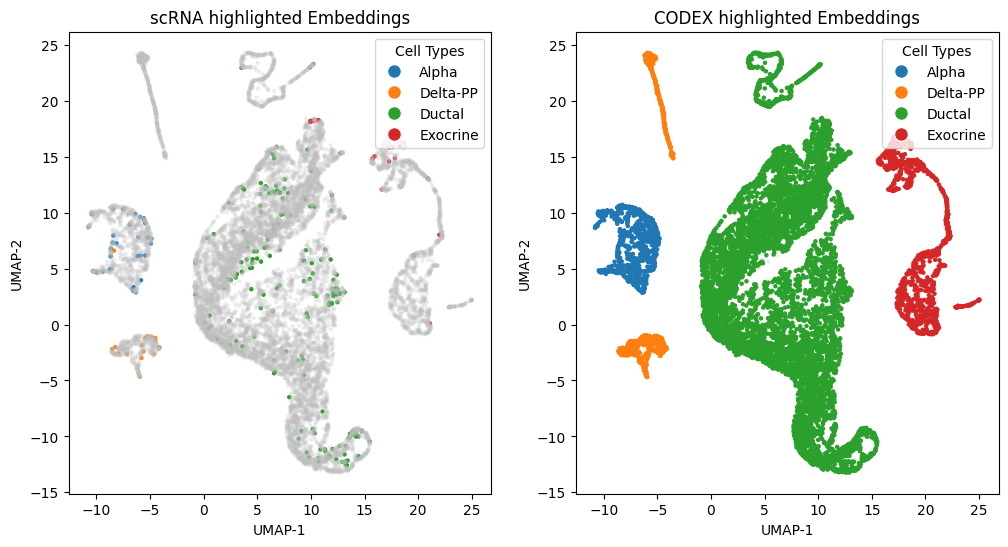

In [22]:
cellink.visualize_integration(ann1_full_batch=combined_adata, ann2_full_batch=protein_adata_filter, arr2_imputed=protein_aligned_rna,
                              datatype= ['scRNA', 'CODEX'], matched_cellids=protein_matched_cellids, direction=1)

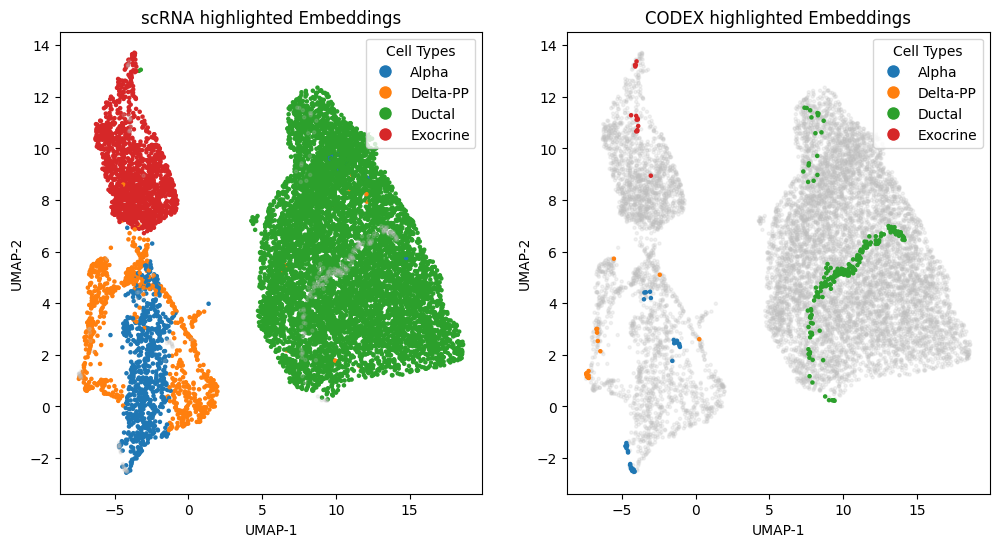

In [23]:
cellink.visualize_integration(ann1_full_batch=protein_adata_filter, ann2_full_batch=combined_adata, arr2_imputed=rna_aligned_protein,
                              datatype= ['CODEX', 'scRNA'], matched_cellids=rna_matched_cellids, direction=2)